In [58]:
#!nvidia-smi

In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import itertools

In [60]:
import os, cv2
import sys
import time
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

# import imgaug
# from imgaug import augmenters as iaa
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("/")
sys.path.append(ROOT_DIR)
from mrcnn import visualize

import skimage.draw
from skimage import io, transform
import pandas as pd

assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

%matplotlib inline

## Calculate mAP

In [61]:
import tensorflow as tf
from distutils.version import LooseVersion
class_names = ['BG', 'scratch', 'scuff', 'dent']

In [62]:
def resize_image_v1(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize_v1(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

In [63]:
def mold_inputs_v1(images):
    """Takes a list of images and modifies them to the format expected
    as an input to the neural network.
    images: List of image matrices [height,width,depth]. Images can have
        different sizes.

    Returns 3 Numpy matrices:
    molded_images: [N, h, w, 3]. Images resized and normalized.
    image_metas: [N, length of meta data]. Details about each image.
    windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
        original image (padding excluded).
    """
    IMAGE_MIN_DIM = 512
    IMAGE_MIN_SCALE = 0
    IMAGE_MAX_DIM = 512
    IMAGE_RESIZE_MODE = "square"
    NUM_CLASSES = 4
    molded_images = []
    image_metas = []
    windows = []
    for image in images:
        # Resize image
        # TODO: move resizing to mold_image()
        molded_image, window, scale, padding, crop = resize_image_v1(
            image,
            min_dim=IMAGE_MIN_DIM,
            min_scale=IMAGE_MIN_SCALE,
            max_dim=IMAGE_MAX_DIM,
            mode=IMAGE_RESIZE_MODE)
        molded_image = mold_image_v1(molded_image)
        # Build image_meta
        image_meta = compose_image_meta_v1(
            0, image.shape, molded_image.shape, window, scale,
            np.zeros([NUM_CLASSES], dtype=np.int32))
        # Append
        molded_images.append(molded_image)
        windows.append(window)
        image_metas.append(image_meta)
    # Pack into arrays
    molded_images = np.stack(molded_images)
    image_metas = np.stack(image_metas)
    windows = np.stack(windows)
    return molded_images, image_metas, windows

In [64]:
def mold_image_v1(images):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
    return images.astype(np.float32) - MEAN_PIXEL

In [65]:
def compose_image_meta_v1(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

In [66]:
def compute_backbone_shapes_v1(image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    BACKBONE = "resnet50"
    BACKBONE_STRIDES = [4, 8, 16, 32, 64] 
#     if callable(BACKBONE):
#         return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in BACKBONE_STRIDES])

In [67]:
def generate_anchors_v1(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

In [68]:
def generate_pyramid_anchors_v1(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors_v1(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

In [69]:
def norm_boxes_v1(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.divide((boxes - shift), scale).astype(np.float32)


In [70]:
def get_anchors_v1(image_shape):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes_v1(image_shape)
    # Cache anchors and reuse if image shape is the same
#     if not hasattr(self, "_anchor_cache"):
    _anchor_cache = {}
    if not tuple(image_shape) in _anchor_cache:
        # Generate Anchors
        RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
        RPN_ANCHOR_RATIOS = [0.5, 1, 2]
        BACKBONE_STRIDES = [4, 8, 16, 32, 64]
        RPN_ANCHOR_STRIDE = 1
        a = generate_pyramid_anchors_v1(RPN_ANCHOR_SCALES,
                                           RPN_ANCHOR_RATIOS,
                                           backbone_shapes,
                                           BACKBONE_STRIDES,
                                           RPN_ANCHOR_STRIDE)
        # Keep a copy of the latest anchors in pixel coordinates because
        # it's used in inspect_model notebooks.
        # TODO: Remove this after the notebook are refactored to not use it
        anchors = a
        # Normalize coordinates
        _anchor_cache[tuple(image_shape)] = norm_boxes_v1(a, image_shape[:2])
    return _anchor_cache[tuple(image_shape)]

In [71]:
def predict_results_v1(img,detections,mask):
    # Process detections
    results = []
    for i, image in enumerate([img]):
        final_rois, final_class_ids, final_scores, final_masks =\
        unmold_detections_v1(detections[i], mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
        results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

In [72]:
def denorm_boxes_v1(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.around(np.multiply(boxes, scale) + shift).astype(np.int32)

In [73]:
def resize_v1(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)

In [74]:
def unmold_mask_v1(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.

    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = resize_v1(mask, (y2 - y1, x2 - x1))
    mask = np.where(mask >= threshold, 1, 0).astype(np.bool)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2], dtype=np.bool)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask

In [75]:
def unmold_detections_v1(detections, mrcnn_mask, original_image_shape,
                      image_shape, window):
    """Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the
    application.

    detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
    mrcnn_mask: [N, height, width, num_classes]
    original_image_shape: [H, W, C] Original image shape before resizing
    image_shape: [H, W, C] Shape of the image after resizing and padding
    window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
            image is excluding the padding.

    Returns:
    boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
    class_ids: [N] Integer class IDs for each bounding box
    scores: [N] Float probability scores of the class_id
    masks: [height, width, num_instances] Instance masks
    """
    # How many detections do we have?
    # Detections array is padded with zeros. Find the first class_id == 0.
    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores = detections[:N, 5]
    masks = mrcnn_mask[np.arange(N), :, :, class_ids]

    # Translate normalized coordinates in the resized image to pixel
    # coordinates in the original image before resizing
    window = norm_boxes_v1(window, image_shape[:2])
    wy1, wx1, wy2, wx2 = window
    shift = np.array([wy1, wx1, wy1, wx1])
    wh = wy2 - wy1  # window height
    ww = wx2 - wx1  # window width
    scale = np.array([wh, ww, wh, ww])
    # Convert boxes to normalized coordinates on the window
    boxes = np.divide(boxes - shift, scale)
    # Convert boxes to pixel coordinates on the original image
    boxes = denorm_boxes_v1(boxes, original_image_shape[:2])

    # Filter out detections with zero area. Happens in early training when
    # network weights are still random
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
    if exclude_ix.shape[0] > 0:
        boxes = np.delete(boxes, exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores = np.delete(scores, exclude_ix, axis=0)
        masks = np.delete(masks, exclude_ix, axis=0)
        N = class_ids.shape[0]

    # Resize masks to original image size and set boundary threshold.
    full_masks = []
    for i in range(N):
        # Convert neural network mask to full size mask
        full_mask = unmold_mask_v1(masks[i], boxes[i], original_image_shape)
        full_masks.append(full_mask)
    full_masks = np.stack(full_masks, axis=-1)\
        if full_masks else np.empty(original_image_shape[:2] + (0,))

    return boxes, class_ids, scores, full_masks

In [76]:
def calc_iou_individual_v1(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

In [77]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [78]:
#### Location for image prediction
#myPath = "../../datasets/damages/unseen"
# myPath = os.path.join("D:\Joe\D\Project\Gdrive\DmiLap\Project\Commercial\GM\images","appteam")
# allFiles = [os.path.join(myPath, file) for file in os.listdir(myPath) if os.path.isfile(os.path.join(myPath, file))]
# fileNames = [file.split("\\")[-1] for file in allFiles]

# class_names = ['BG', 'scratch', 'scuff', 'dent']

In [79]:
# DAMAGE_DIR = os.path.join("D:\Joe\D\Project\Gdrive\DmiLap\Project\Commercial\GM\images", "Batch1")
# real_test_dir = os.path.join(DAMAGE_DIR,"val")
# allFiles = []
# image_list = ['set7_Scuff_204.jpg',
# 'set7_Scuff_378.jpg',
# 'set7_Scuff_342.jpg',
# 'dent_set5_197.jpg',
# 'set7_Scuff_507.jpg',
# 'dent_set3_361.jpg',
# 'set1_Scratch_99.jpg',
# 'set1_Scratch_109.jpg',
#  'set1_Scratch_135.jpg',
#  'dent_set5_149.jpg',
#  'set7_Scuff_356.jpg'
# ]

# for filename in image_list:
#     if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
#         allFiles.append(os.path.join(real_test_dir, filename))
        

In [80]:
#fileNames[]

In [81]:
model_abs_path =  r"D:\GM\code\Prediction-Test\model"

In [82]:
tflite_model_path = os.path.join(model_abs_path,"mask_rcnn_damages_0076_1.53_VM.tflite")

In [83]:
print(tflite_model_path)

D:\GM\code\Prediction-Test\model\mask_rcnn_damages_0076_1.53_VM.tflite


In [84]:
# Load images from the unseen folder
DAMAGE_DIR = os.path.join("D:\GM\qa\myTestImages")
real_test_dir = os.path.join(DAMAGE_DIR,r"Test2\DJ-March-23")
image_paths = []
image_list = next(os.walk(real_test_dir))[2]

for filename in image_list:
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
        
class_names = ['BG', 'scratch', 'scuff', 'dent']

print(image_list)

['58d6f382-ce81-443e-b41c-8a3dcb4213a6.jpg', '97342cd1-61d4-4b5c-b78b-d1e66d94b7ef.jpg', '9e3f17ad-f1c3-4abb-8b8f-db457ae74915.jpg']


processing image D:\GM\qa\myTestImages\Test2\DJ-March-23\58d6f382-ce81-443e-b41c-8a3dcb4213a6.jpg...............................
(image mode is RGB)
(754, 2772, 3)
(754, 2772, 3)
detections shape is (1, 100, 6)
mask shape is (1, 100, 28, 28, 4)

*** No instances to display *** 



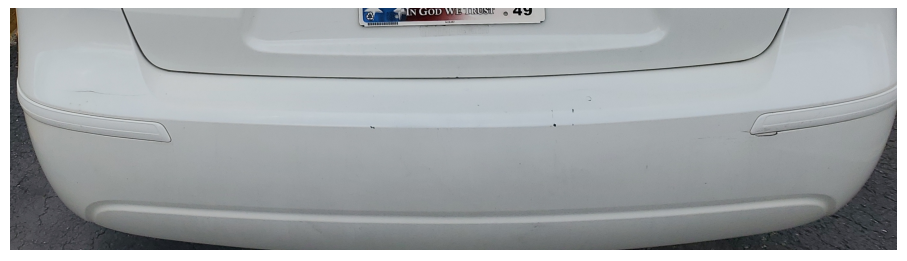

processing image D:\GM\qa\myTestImages\Test2\DJ-March-23\97342cd1-61d4-4b5c-b78b-d1e66d94b7ef.jpg...............................
(image mode is RGB)
(1280, 1465, 3)
(1280, 1465, 3)
detections shape is (1, 100, 6)
mask shape is (1, 100, 28, 28, 4)

*** No instances to display *** 



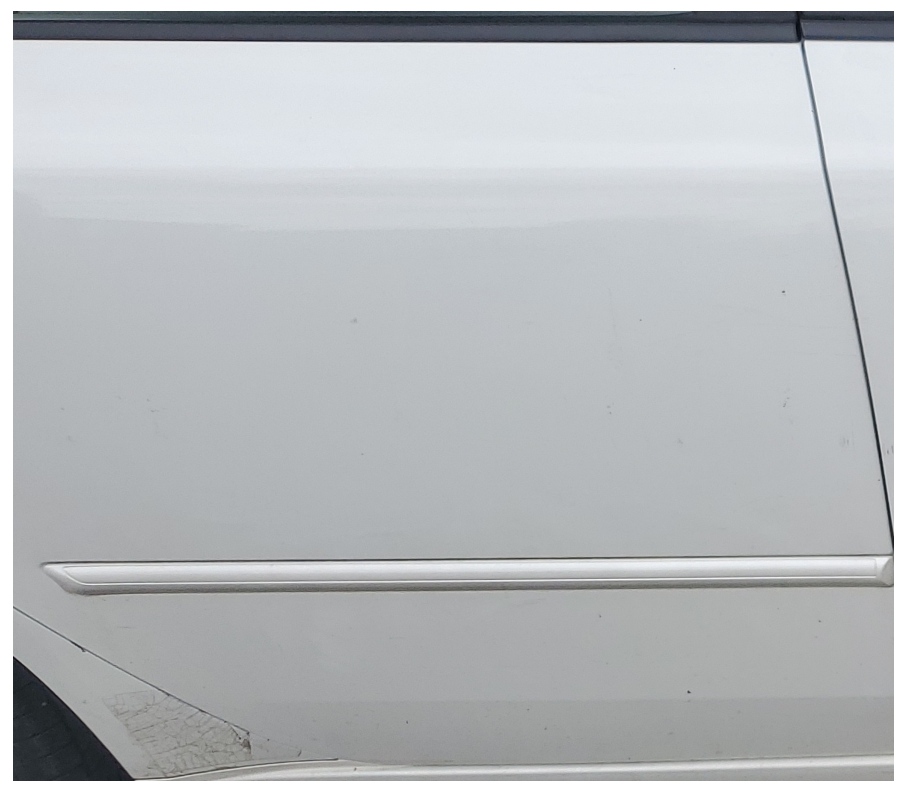

processing image D:\GM\qa\myTestImages\Test2\DJ-March-23\9e3f17ad-f1c3-4abb-8b8f-db457ae74915.jpg...............................
(image mode is RGB)
(1375, 2609, 3)
(1375, 2609, 3)
detections shape is (1, 100, 6)
mask shape is (1, 100, 28, 28, 4)

*** No instances to display *** 



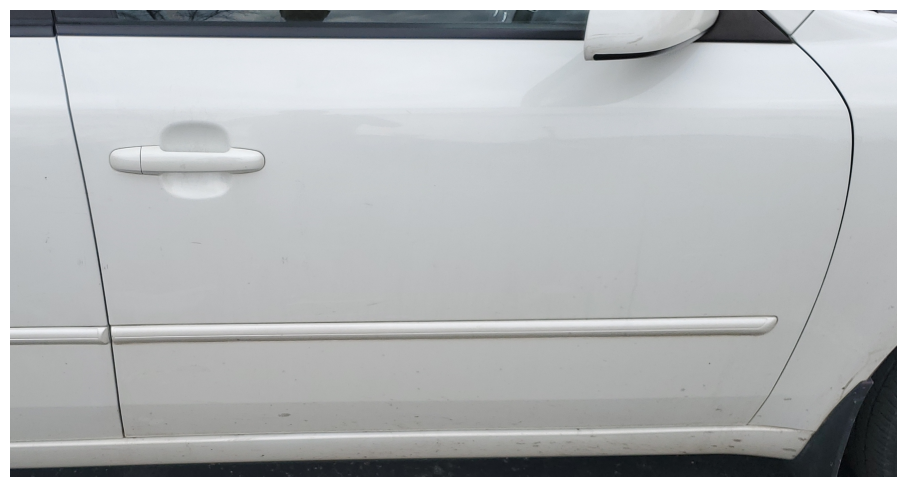

In [85]:
from PIL import Image

predFileBoxesScoresJsonAll = {}
for file in image_paths:
    
    print(f'processing image {file}...............................')
    
    cmykImage = Image.open(file)
    mode = cmykImage.mode
    
    print(f'(image mode is {mode})')
   
    image = io.imread(file)
    
    img_arr = np.array(image)
    
    print(img_arr.shape)
    
    img_arr = img_arr[:, :, :3]
    
    image = img_arr
    
    print(image.shape)   
    
    # derive image shape, meta and anchors
    molded_images, image_metas, windows = mold_inputs_v1([image])
    image_shape = molded_images[0].shape
    anchors = get_anchors_v1(image_shape)
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    BATCH_SIZE = IMAGES_PER_GPU * GPU_COUNT
    anchors = np.broadcast_to(anchors, (BATCH_SIZE,) + anchors.shape)
    

    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data_1 = np.array(molded_images, dtype=np.float32)
    input_data_2 = np.array(image_metas, dtype=np.float32)
    input_data_3 = np.array(anchors, dtype=np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data_1)
    interpreter.set_tensor(input_details[1]['index'], input_data_2)
    interpreter.set_tensor(input_details[2]['index'], input_data_3)

    interpreter.invoke()
    
    # output_details

    detections_lite = interpreter.get_tensor(output_details[3]['index'])
    mrcnn_mask_lite = interpreter.get_tensor(output_details[4]['index'])
    lite_results = predict_results_v1(image,detections_lite,mrcnn_mask_lite)
    
    print(f'detections shape is {detections_lite.shape}')
    print(f'mask shape is {mrcnn_mask_lite.shape}')

    final_results = lite_results[0]
    #print(final_results)

    final_results_roi = final_results['rois'].tolist()
    
#     sys.exit()
    
    final_results_roi_nodups = list(k for k,_ in itertools.groupby(final_results_roi))
    final_results_roi_nodups_indexes = [final_results_roi.index(element) for element in final_results_roi_nodups]

    final_results_scores = final_results['scores'].tolist()
    final_results_scores_nodups = [final_results_scores[i] for i in final_results_roi_nodups_indexes] 
    
    final_results_labels = final_results['class_ids'].tolist()
    final_results_labels_nodups = [final_results_labels[i] for i in final_results_roi_nodups_indexes] 
    
    ### JSON of predictions
    predFile = file.split("//")[-1]
    predBoxesScoresJson = {"boxes":final_results_roi_nodups, "scores":final_results_scores_nodups, 
                           "labels":final_results_labels_nodups}
    predFileBoxesScoresJson = {predFile:predBoxesScoresJson}
    
    #### Appending predicted JSON
    predFileBoxesScoresJsonAll = {**predFileBoxesScoresJsonAll,**predFileBoxesScoresJson}
    
    visualize.display_instances(image, final_results['rois'], final_results['masks'], final_results['class_ids'], 
                                class_names, final_results['scores'], show_mask=False)
    
#predFileBoxesScoresJsonAll

In [86]:
sys.exit()

SystemExit: 

In [50]:
predFileBoxesScoresJsonAll

{'D:\\GM\\qa\\myTestImages\\Test2\\Jazz-March-22\\12bba84b-83ff-4720-91eb-c5074a077809.jpg': {'boxes': [],
  'scores': [],
  'labels': []},
 'D:\\GM\\qa\\myTestImages\\Test2\\Jazz-March-22\\29b661f2-1e96-4b9d-9f2b-e637dc478ede.jpg': {'boxes': [],
  'scores': [],
  'labels': []},
 'D:\\GM\\qa\\myTestImages\\Test2\\Jazz-March-22\\452907fc-d34e-440d-8f79-012731f2a87a.jpg': {'boxes': [[3,
    327,
    75,
    416],
   [5, 326, 75, 416]],
  'scores': [0.9248012900352478, 0.9155550003051758],
  'labels': [3, 3]},
 'D:\\GM\\qa\\myTestImages\\Test2\\Jazz-March-22\\8526905c-a560-4c92-ab7a-21175f6bd44a.jpg': {'boxes': [[70,
    543,
    170,
    630],
   [74, 528, 167, 632]],
  'scores': [0.8805269002914429, 0.8555842041969299],
  'labels': [3, 3]},
 'D:\\GM\\qa\\myTestImages\\Test2\\Jazz-March-22\\95155f41-3722-41b7-ac24-e3b64e4aaa56.jpg': {'boxes': [[34,
    455,
    132,
    572],
   [40, 475, 128, 570]],
  'scores': [0.8513466715812683, 0.7198150157928467],
  'labels': [3, 3]},
 'D:\\GM\\qa\

In [51]:
print(image_shape)

(512, 512, 3)


In [52]:
input_data_1.dtype

dtype('float32')

In [53]:
print(anchors)

[[[-0.04428066 -0.02214033  0.04232371  0.02018338]
  [-0.03131115 -0.03131115  0.02935421  0.02935421]
  [-0.02214033 -0.04428066  0.02018338  0.04232371]
  ...
  [ 0.16822177  0.5224671   1.583246    1.2290007 ]
  [ 0.37573385  0.37573385  1.3757339   1.3757339 ]
  [ 0.5224671   0.16822177  1.2290007   1.583246  ]]]


In [54]:
input_data_3

array([[[-0.04428066, -0.02214033,  0.04232371,  0.02018338],
        [-0.03131115, -0.03131115,  0.02935421,  0.02935421],
        [-0.02214033, -0.04428066,  0.02018338,  0.04232371],
        ...,
        [ 0.16822177,  0.5224671 ,  1.583246  ,  1.2290007 ],
        [ 0.37573385,  0.37573385,  1.3757339 ,  1.3757339 ],
        [ 0.5224671 ,  0.16822177,  1.2290007 ,  1.583246  ]]],
      dtype=float32)

In [55]:
print(input_data_3.shape)

(1, 65472, 4)


In [56]:
print(f'detections shape is {detections_lite.shape}'),print(f'mask shape is {mrcnn_mask_lite.shape}')

detections shape is (1, 100, 6)
mask shape is (1, 100, 28, 28, 4)


(None, None)

In [57]:
molded_images.shape,image_metas.shape,anchors.shape

((1, 512, 512, 3), (1, 16), (1, 65472, 4))

In [58]:
molded_images, image_metas, windows

(array([[[[-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          ...,
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9]],
 
         [[-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          ...,
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9]],
 
         [[-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          ...,
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9]],
 
         ...,
 
         [[-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          ...,
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9],
          [-123.7, -116.8, -103.9]],
 
         [[-123.7, -116.8, -103.9],
          [-

In [59]:
#lite_results[0]

In [60]:
#file
#image

In [61]:
def draw_box(image, box, color, thickness=2):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    xy = (b[0], b[1])
    x1y1 = (b[2], b[3])
    print (xy)
    print (x1y1)
    print (b[0], b[1])
    print (b[2], b[3])
    cv2.rectangle(image, tuple([xy, x1y1, tuple(color), thickness]))#, cv2.LINE_AA)

In [62]:
434, 1000, 1066, 1565

(434, 1000, 1066, 1565)

In [63]:
op_image = cv2.rectangle(image,pt1=(1000,434),pt2=(1565,1066),color=(255,255,255),thickness=10)

(0.0, 1.0, 0.0, 1.0)

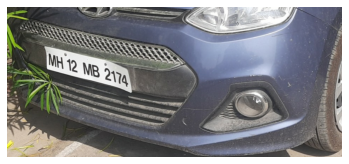

In [64]:
#plt.figure(figsize=(10,10))
plt.axis('off')

plt.imshow(op_image)
plt.show()

In [65]:
draw_box(file,[292,1026,1137,1682],color=(255,255,255))

(292, 1026)
(1137, 1682)
292 1026
1137 1682


TypeError: rectangle() missing required argument 'color' (pos 3)

## IMAGE INPUTS

In [ ]:
IMAGE_MIN_DIM = 512
IMAGE_MIN_SCALE = 0
IMAGE_MAX_DIM = 512
IMAGE_RESIZE_MODE = "square"
NUM_CLASSES = 4

In [ ]:
molded_image, window, scale, padding, crop = resize_image_v1(
            image,
            min_dim=IMAGE_MIN_DIM,
            min_scale=IMAGE_MIN_SCALE,
            max_dim=IMAGE_MAX_DIM,
            mode=IMAGE_RESIZE_MODE)

In [ ]:
print(0, image.shape, molded_image.shape, window, scale,np.zeros([NUM_CLASSES]))

In [ ]:
image_meta = compose_image_meta_v1(
            0, image.shape, molded_image.shape, window, scale,
            np.zeros([NUM_CLASSES], dtype=np.int32))

In [ ]:
image_id = 0

In [ ]:
# meta = np.array(
#         [image_id] +                  # size=1
#         list(original_image_shape) +  # size=3
#         list(image_shape) +           # size=3
#         list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
#         [scale] +                     # size=1
#         list(active_class_ids)        # size=num_classes
#     )

In [ ]:
image_meta

In [ ]:
image_metas ### [N, length of meta data]. Details about each image.

In [ ]:
#molded_images ### [N, h, w, 3]. Images resized and normalized.
# image
# var_mean_pixel = np.array([123.7, 116.8, 103.9])
# molded_image_op = image.astype(np.float32) - var_mean_pixel
# print(molded_image_op)
print(molded_images.shape)

In [ ]:
windows ### [N, (y1, x1, y2, x2)]. The portion of the image that has the original image (padding excluded).

In [ ]:
anchors ### anchor pyramid for the given image size

In [ ]:
np.array_str(anchors)

In [ ]:
with open('anchors.txt',mode='w') as f:
    f.write(np.array2string(anchors))

In [ ]:
anchors.shape

In [ ]:
anchors_s = np.squeeze(anchors)

In [ ]:
anchors_s.shape

In [ ]:
np.savetxt('anchors.txt',anchors_s)

In [ ]:
final_results_labels_nodups
final_results_scores_nodups
final_results_roi_nodups

In [ ]:
labelsDict = {0:'BG', 1:'scratch', 2:'scuff', 3:'dent'}

#### Read complete GT file
gtFile = pd.read_csv("Filtered_Consolidated_Rectangle_Formatted_All.csv")



#### JSON of ground truth only for predicted images
gtFilePredicted = gtFile[gtFile["image_name"].isin(fileNames)]
gtBoxesJson = gtFilePredicted.groupby('image_name')[['x_min', 'y_min', 'x_max','y_max']].apply(lambda 
                                                                                               g: g.values.tolist()).to_dict()

In [ ]:
    ###################################################################################################################
    ## show predictions with ground truth
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)    
    
    #### Get corresponding ground truth
    rowFromGt = gtFile[gtFile["image_name"]==predFile]
    gtBoxes = rowFromGt[["x_min","y_min","x_max","y_max"]].values
    gtLabels = [element+"gt" for element in rowFromGt["class_name"].values.tolist()]
    gtLabels = np.asarray(list(map(labelsDict.get, gtLabels)))
    gtScores = np.asarray([1.0] * len(gtLabels))
    
    #### Concatenate both ground truth and prediction for display in same image
    predAndGtBoxes = np.concatenate([gtBoxes, final_results_roi_nodups])
    predAndGtLabels = np.concatenate([gtLabels, final_results_labels_nodups])
    predAndGtScores = np.concatenate([gtScores, final_results_scores_nodups])
    
    ##### Show IOU individual predicted box
    print ("IMAGE NAME == "+str(predFile))
    print ("~" * 50)

    for gtbox in gtBoxes:
        topIouScore = 0
        topPredBox = []

        for predbox,predlabel in zip(boxes[0], labels[0]):
            if predlabel > -1:
                iouScore = calc_iou_individual_v1(predbox, gtbox)

                if iouScore > topIouScore:
                    topPredBox = predbox
                    topIouScore = iouScore

        print ("Ground truth box               : " + str(gtbox))
        print ("Predicted box - Max ONLY       : " + str(topPredBox.tolist()))
        print ("IOU Score                      : " + str(topIouScore))
        print ('**' * 20)
    
    #### THRES_SCORE for the number of gt boxes - Predicted box count = Gt box count
    THRES_SCORE = final_results_scores_nodups[len(gtBoxes)-1] - 1e-10
    draw_detections_withGt(draw, predAndGtBoxes, predAndGtScores, predAndGtLabels)

    plt.figure(figsize=(10,10))
    plt.axis('off')

    plt.imshow(draw)
    plt.show()
    
    print ("#####" * 50)
    break

In [ ]:
predFileBoxesScoresJsonAll

In [ ]:
img = cv2.imread(allFiles[0:1][0])
predAndGtBoxes[0]
b = np.array(predAndGtBoxes[0]).astype(int)
xy = (b[0], b[1])
x1y1 = (b[2], b[3])
xy
x1y1
img.shape
# Blue color in BGR 
c1 = [255, 57, 0]
color = tuple(c1) 
color
# Line thickness of 2 px 
thickness = 2
cv2.rectangle(draw, xy, x1y1, color, thickness)

In [ ]:
draw_detections_withGt(draw, predAndGtBoxes, predAndGtScores, predAndGtLabels)

plt.figure(figsize=(10,10))
plt.axis('off')

plt.imshow(draw)
plt.show()
    
print ("#####" * 50)

In [ ]:
tuple([b[0], b[1]])

In [ ]:
def draw_box(image, box, color, thickness=2):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    xy = (b[0], b[1])
    x1y1 = (b[2], b[3])
    print (xy)
    print (x1y1)
    print (b[0], b[1])
    print (b[2], b[3])
    cv2.rectangle(image, tuple([xy, x1y1, tuple(color), thickness]))#, cv2.LINE_AA)

In [ ]:
draw_box()

In [ ]:
def draw_detections_withGt(image, boxes, scores, labels):
    for box, score, label in zip(boxes, scores, labels):
        if score < THRES_SCORE:
            break
        
        color = label_color(label)
        b = box.astype(int)
        draw_box(image, b, color=color, thickness=2)

        caption = "{} {:.2f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [ ]:
def label_color(label):
    """ Return a color from a set of predefined colors. Contains 80 colors in total.

    Args
        label: The label to get the color for.

    Returns
        A list of three values representing a RGB color.

        If no color is defined for a certain label, the color green is returned and a warning is printed.
    """
    colors = [list((matplotlib.colors.hsv_to_rgb([x, 1.0, 1.0]) * 255).astype(int)) for x in np.arange(0, 1, 1.0 / 80)]
    label = int(label)
    if label < len(colors):
        return colors[label]
    else:
        warnings.warn('Label {} has no color, returning default.'.format(label))
        return (0, 255, 0)

In [ ]:
label_color(3)